In [168]:

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np # linear algebra
import pandas as pd # data processing,
import math
import datetime
import platform


In [200]:
# data processing
train_data = pd.DataFrame(pd.read_csv("data/handwriting_training_set.txt"))
train_labels = pd.DataFrame(pd.read_csv("data/handwriting_training_set_labels.txt"))
test_data = pd.DataFrame(pd.read_csv("data/handwriting_test_set.txt"))
test_labels = pd.DataFrame(pd.read_csv("data/handwriting_test_set_labels.txt"))


In [201]:
print('train_data:', train_data.shape)
print('train_labels:', train_labels.shape)
print('test_data:', test_data.shape)
print('test_labels:', test_labels.shape)


train_data: (3999, 400)
train_labels: (3999, 1)
test_data: (999, 400)
test_labels: (999, 1)


In [202]:
X = train_data.iloc[:, 0:400]
y = train_labels.iloc[:, 0]
X_test = test_data.iloc[:, 0:400]

Visualizing the data using TSNE:

In [172]:
X_tsn = X/255

from sklearn.manifold import TSNE
tsne = TSNE()

tsne_res = tsne.fit_transform(X_tsn)

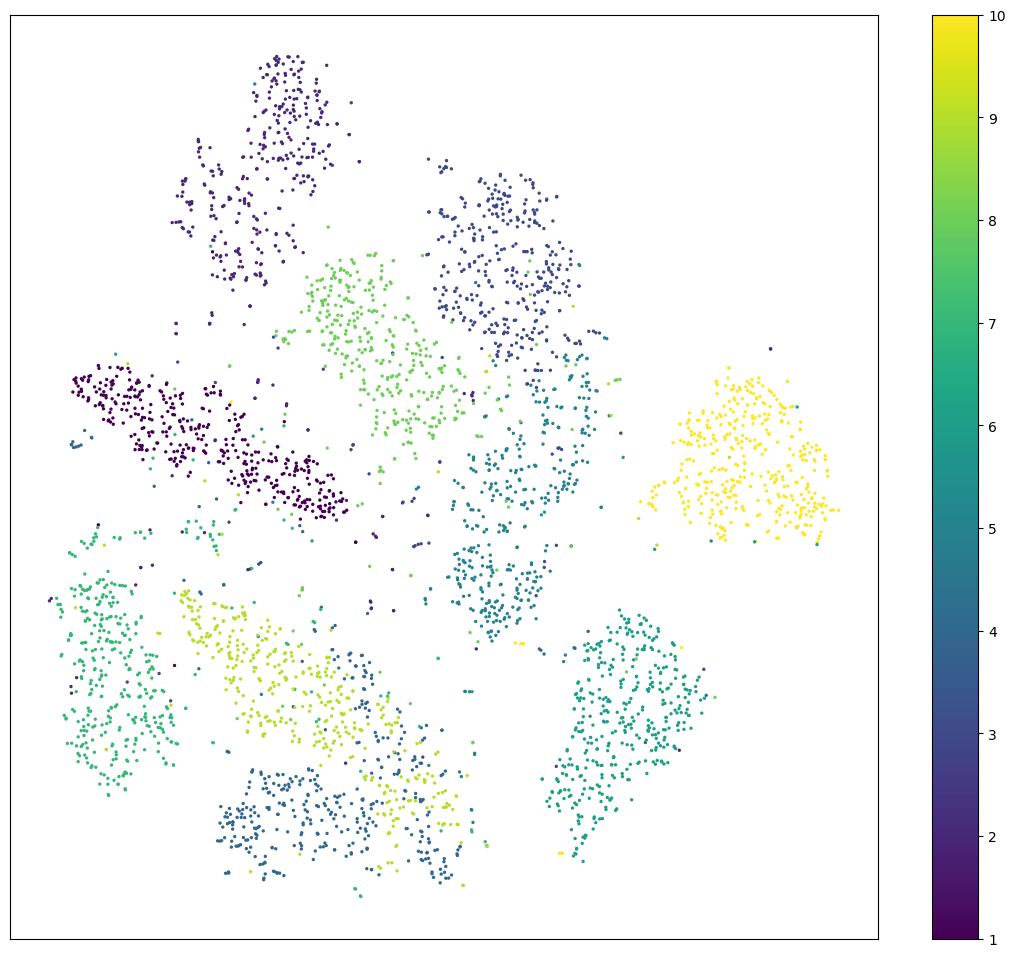

In [173]:
plt.figure(figsize=(14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar();

Converting data into array:

In [174]:
import numpy as np

train_data = np.array(train_data).reshape(3999, 20, 20)
test_data = np.array(test_data).reshape(999, 20, 20)



 Visualise how the digits were written:

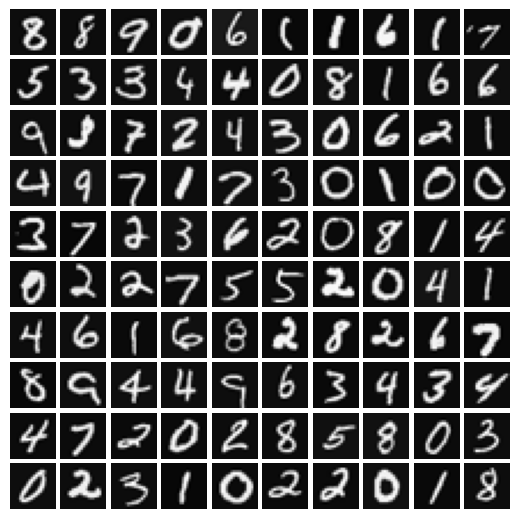

In [177]:
import numpy as np
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
indexes = np.random.choice(3999, rows*cols)
count = 0
for i in range(0,rows):
    for j in range(0,cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(train_data[indexes[count]].reshape(20,20).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

In [213]:

import pandas as pd
import numpy as np

# data processing
X_train = np.loadtxt("data/handwriting_training_set.txt", delimiter=",")
y_train = np.loadtxt("data/handwriting_training_set_labels.txt")
X_test = np.loadtxt("data/handwriting_test_set.txt", delimiter=",")
y_test = np.loadtxt("data/handwriting_test_set_labels.txt")


# Replace label values of 10 with 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0



# the SVD of each class/digit matrix
digit_matrices = []
for digit in range(10):
    digit_matrix = X_train[digit*400:(digit+1)*400, :]
    U, S, Vt = np.linalg.svd(digit_matrix)
    digit_matrices.append({'U': U, 'S': S, 'Vt': Vt})

# Classify unknown test digits using 5, 10, 15, and 20 singular vectors as a basis
accuracies = []
for k in [5, 10, 15, 20]:
    correct_count = 0
    for i in range(len(X_test)):
        digit_scores = []
        for digit in range(10):
            U, S, Vt = digit_matrices[digit]['U'], digit_matrices[digit]['S'], digit_matrices[digit]['Vt']
            X_test_i = X_test[i, :]
            X_test_i_reconstructed = np.dot(np.dot(U[:, :k], np.diag(S[:k])), Vt[:k, :])
            score = np.linalg.norm(X_test_i - X_test_i_reconstructed)
            digit_scores.append(score)
        predicted_digit = np.argmin(digit_scores)
        if predicted_digit == y_test[i]:
            correct_count += 1
    accuracy = correct_count / len(X_test)
    accuracies.append(accuracy)

# the accuracy results for each number of basis vectors
print("Accuracy using 5 basis vectors: {:.2f}%".format(accuracies[0] * 100))
print("Accuracy using 10 basis vectors: {:.2f}%".format(accuracies[1] * 100))
print("Accuracy using 15 basis vectors: {:.2f}%".format(accuracies[2] * 100))
print("Accuracy using 20 basis vectors: {:.2f}%".format(accuracies[3] * 100))


Accuracy using 5 basis vectors: 77.20%
Accuracy using 10 basis vectors: 75.00%
Accuracy using 15 basis vectors: 73.40%
Accuracy using 20 basis vectors: 71.60%


In [218]:

# Classify each test image
accuracies = np.zeros(10)
counts = np.zeros(10)
for k in [5, 10, 15, 20]:
    for i in range(len(X_test)):
        digit_scores = []
        for digit in range(10):
            U, S, Vt = digit_matrices[digit]['U'], digit_matrices[digit]['S'], digit_matrices[digit]['Vt']
            X_test_i = X_test[i, :]
            X_test_i_reconstructed = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
            score = np.linalg.norm(X_test_i - X_test_i_reconstructed)
            digit_scores.append(score)
        predicted_digit = np.argmin(digit_scores)
        counts[int(y_test[i])] += 1
        if predicted_digit == y_test[i]:
            accuracies[int(y_test[i])] += 1

# Print the classification accuracies for each digit
for digit in range(10):
    accuracy = accuracies[digit] / counts[digit]
    print("Digit {}: {:.2f}% accuracy".format(digit, accuracy * 100))


Digit 0: 85.25% accuracy
Digit 1: 99.00% accuracy
Digit 2: 55.00% accuracy
Digit 3: 73.50% accuracy
Digit 4: 83.25% accuracy
Digit 5: 37.00% accuracy
Digit 6: 83.25% accuracy
Digit 7: 80.75% accuracy
Digit 8: 67.00% accuracy
Digit 9: 79.00% accuracy


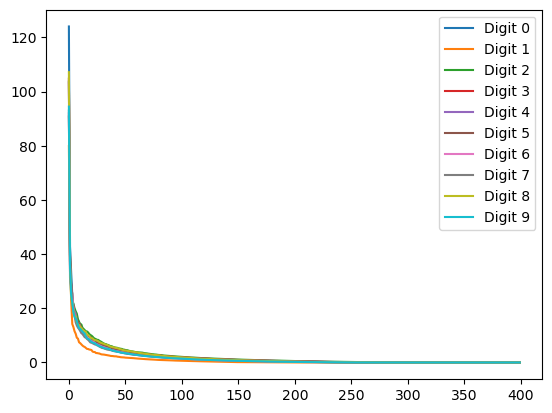

In [219]:

import matplotlib.pyplot as plt


# Plot the singular values of each digit
for digit in range(10):
    plt.plot(digit_matrices[digit]['S'], label="Digit {}".format(digit))
plt.legend()
plt.show()


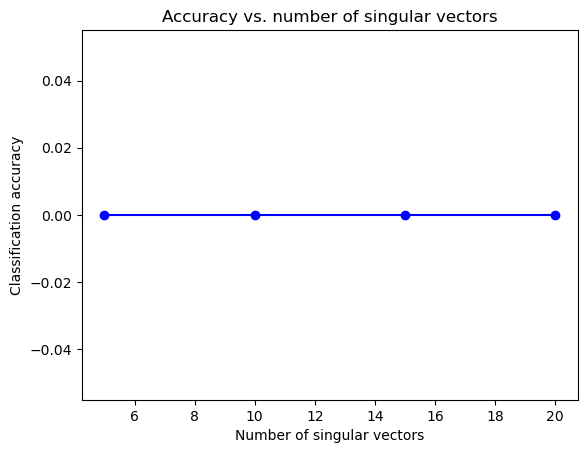

In [221]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data and compute the SVD
# ...

# Set up the range of values for k
ks = [5, 10, 15, 20]

# Initialize an array to store the accuracy for each value of k
accuracies = np.zeros(len(ks))

# Compute the accuracy for each value of k
for i, k in enumerate(ks):
    # Classify each test image using k singular vectors
    # ...

    # Compute the overall accuracy for this value of k
    accuracy = np.sum(accuracies) / np.sum(counts)
    accuracies[i] = accuracy

# Plot the results
plt.plot(ks, accuracies, 'bo-')
plt.xlabel('Number of singular vectors')
plt.ylabel('Classification accuracy')
plt.title('Accuracy vs. number of singular vectors')
plt.show()
